In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
import sys
sys.path.append("../")

import torch, os
import numpy as np
from PIL import Image
from huggingface_hub import snapshot_download
from prompt2prompt.pipeline_prompt2prompt import Prompt2PromptPipeline
from prompt2prompt.ptp_utils import AttentionStore, AttentionReplace, LocalBlend, AttentionRefine, AttentionReweight, view_images, get_equalizer, text_under_image_pil, text_under_image
from converter import load_wav, mel_spectrogram, normalize_spectrogram, denormalize_spectrogram, Generator, get_mel_spectrogram_from_audio
from utils import pad_spec, image_add_color, torch_to_pil, normalize, denormalize, prepare_mask_and_masked_image, numpy_to_pil
from matplotlib import pyplot as plt
from IPython.display import display, Audio

In [3]:
pretrained_model_name_or_path = "auffusion/auffusion-full-no-adapter"
dtype = torch.float16
device = "cuda"

In [ ]:
if not os.path.isdir(pretrained_model_name_or_path):
    pretrained_model_name_or_path = snapshot_download(pretrained_model_name_or_path) 

In [4]:
vocoder = Generator.from_pretrained(pretrained_model_name_or_path, subfolder="vocoder")
vocoder = vocoder.to(device=device, dtype=dtype)

In [5]:
pipe = Prompt2PromptPipeline.from_pretrained(pretrained_model_name_or_path, torch_dtype=dtype)
pipe = pipe.to(device)

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 100000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [6]:
### Choices
prompt = "A man is speaking in a huge room"
word_select = ("huge",)
weight_list = (3,)
cross_replace_steps = .8
self_replace_steps  = .8
NUM_DIFFUSION_STEPS = 50
seed = 2333


prompt = "chopping potatoes on a metal table."
word_select = ("chopping",)
weight_list = (4,)
cross_replace_steps = .8
self_replace_steps  = .8
NUM_DIFFUSION_STEPS = 50
seed = 2333

In [ ]:
# Generation
g_cpu = torch.Generator().manual_seed(seed)

prompts = [prompt] * 2
equalizer = get_equalizer(prompts[1], word_select, weight_list, tokenizer=pipe.tokenizer)

controller = AttentionReweight(prompts, NUM_DIFFUSION_STEPS, cross_replace_steps=cross_replace_steps,
                                self_replace_steps=self_replace_steps,tokenizer=pipe.tokenizer,
                                device=pipe.device,
                                equalizer=equalizer,)
outputs = pipe(prompt=prompts, height=256, width=1024, num_inference_steps=NUM_DIFFUSION_STEPS,
                controller=controller, generator=g_cpu, output_type="pt")

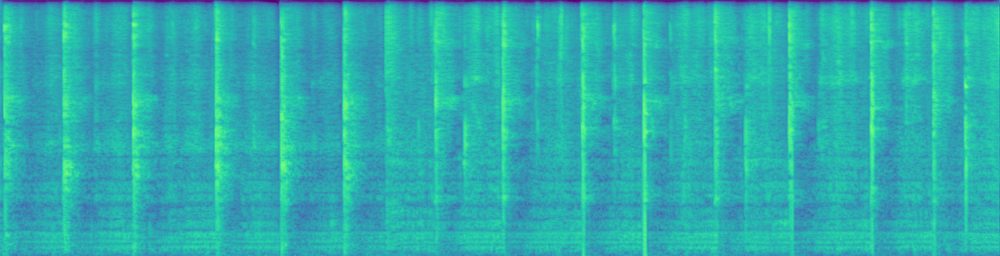

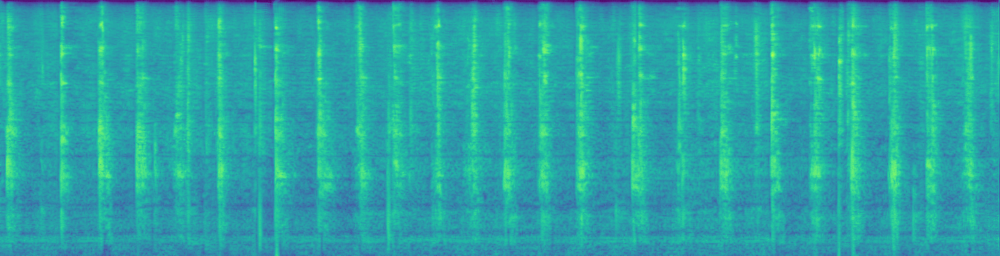

In [8]:
# Show image results
images = numpy_to_pil(outputs.images[:,:,:1000])

for i in range(len(images)):
    color_image = view_images(np.array(image_add_color(images[i])))

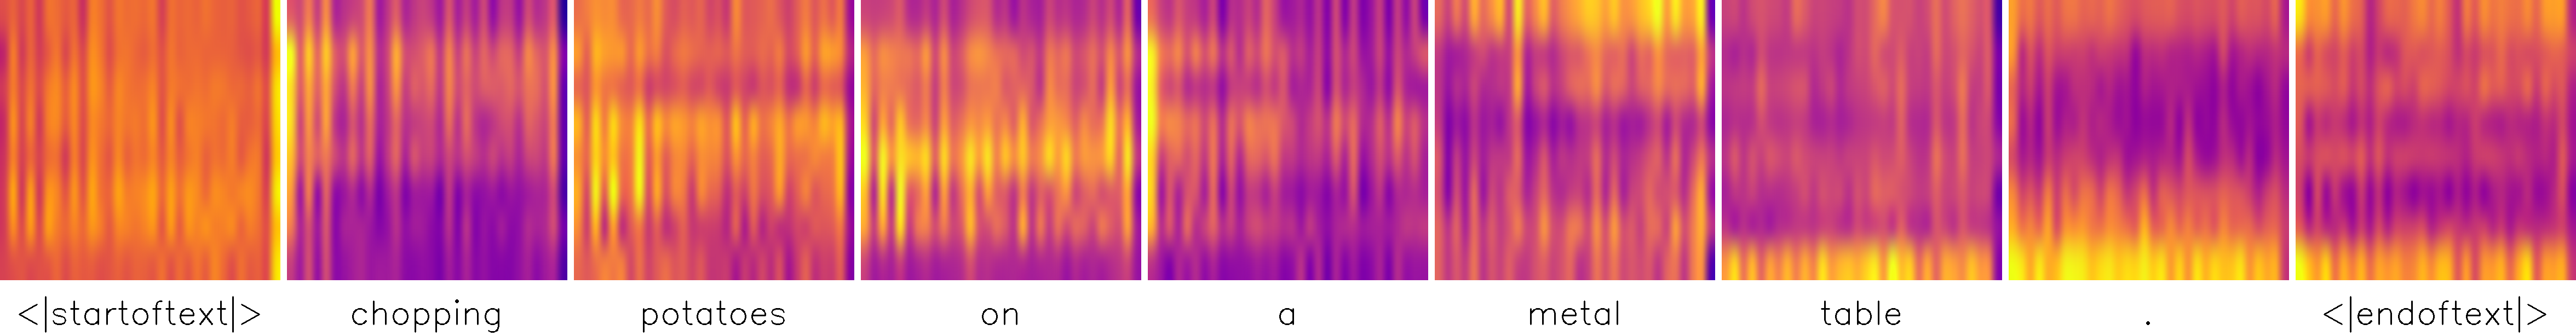

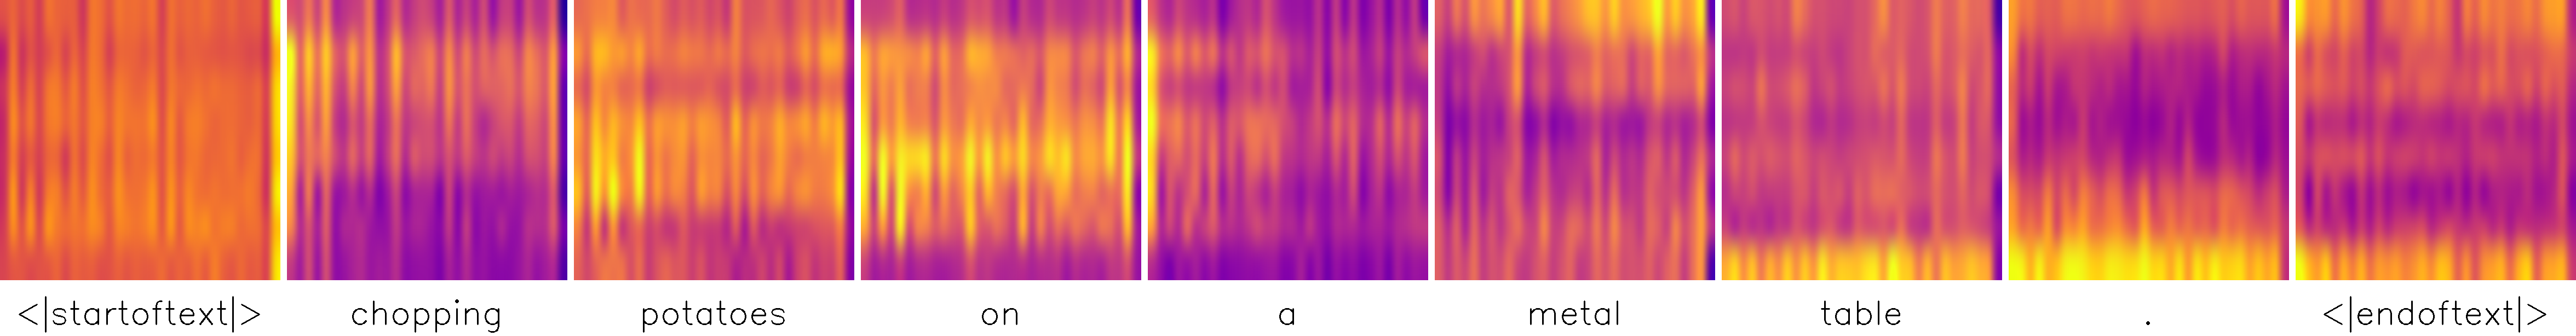

In [9]:
# Show attention maps
for i in range(len(prompts)):
    attn_image = pipe.show_cross_attention(prompts, controller, res=[8,32], image_size=[512,512], from_where=("up", "down"), select=i, num_rows=1)

In [10]:
# Show audio results
for i in range(len(prompts)):
    spec = torch.from_numpy(outputs.images.transpose(0, 3, 1, 2)[i]).to(device, dtype)
    denorm_spec = denormalize_spectrogram(spec)
    denorm_spec_audio = vocoder.inference(denorm_spec)
    display(Audio(denorm_spec_audio, rate=16000))